In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime




In [20]:
file_path = '11b_zeroshot_drinks_visualassets.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [21]:
arcom_df = pd.read_csv("/Users/thibaultrolland/Projects/arcom/data/ARCOM.csv")

def clean_themes(themes):
    if type(themes) == str:
        themes = themes.split(',')
        themes = [theme.strip() for theme in themes]
        themes = [theme.lower() for theme in themes]
        return themes
    return []

arcom_df['clean_theme'] = arcom_df['Thème'].apply(clean_themes)
arcom_df['clean_date'] = [datetime.datetime.strptime(x, '%d/%m/%Y').date() for x in arcom_df['Date']]

food_sectors = ['BOISSONS']
food_df = arcom_df[[sector in food_sectors for sector in arcom_df['Secteur']]]
food_df = food_df[~food_df['Script'].isna()]
food_df = food_df[~food_df['Visuel'].isna()]
food_df['original_index'] = food_df.index

/var/folders/cf/xcc222mj0yg3dzy7mljbx99w0000gn/T/ipykernel_58997/899044587.py:1: DtypeWarning: Columns (37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  arcom_df = pd.read_csv("/Users/thibaultrolland/Projects/arcom/data/ARCOM.csv")


In [22]:
labels = data[0]['labels']

In [23]:
labels

['animaux',
 'Paysage',
 'ruralité',
 'Danse',
 'Saga',
 'Mascotte',
 'Famille',
 'Recette',
 'bonne humeur',
 'enfants',
 'parents',
 'interpellation']

In [24]:
for row in data:
    row['score_by_label'] = dict(zip(row['labels'], row['scores']))

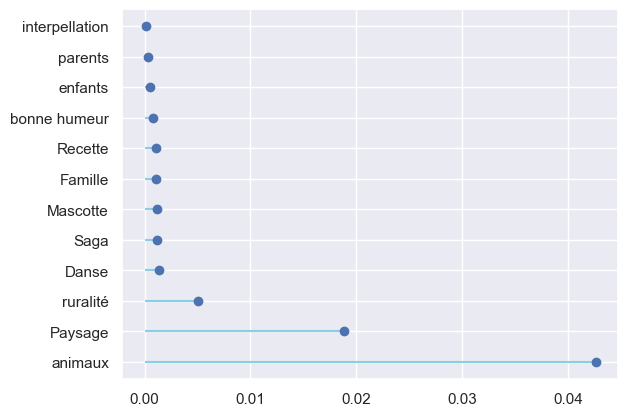

In [25]:
# plot of single ad

labels = data[0]['labels']
scores = data[0]['scores']

plt.hlines(y=range(1, len(labels) + 1), xmin=0,xmax=scores, color='skyblue')
plt.plot(scores, range(1, len(labels)+1), 'o')
plt.yticks(range(1, len(labels)+1), labels)
plt.show()

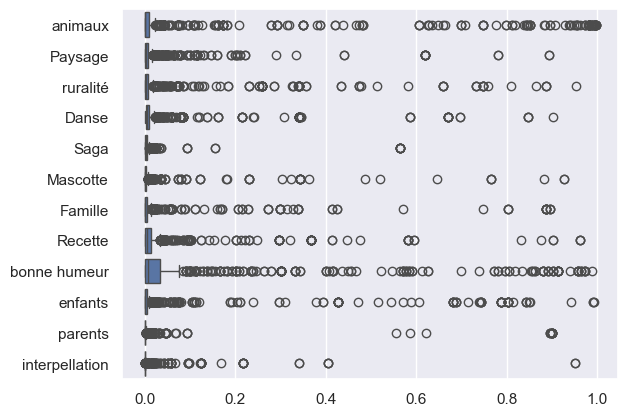

In [26]:
# all ads in boxplot

labels_bp_list = list(itertools.chain(*[x['labels'] for x in data]))
scores_bp_list = list(itertools.chain(*[x['scores'] for x in data]))

sns.set_theme(style="darkgrid")
sns.boxplot(y=labels_bp_list, x=scores_bp_list)
plt.show()

<AxesSubplot:>

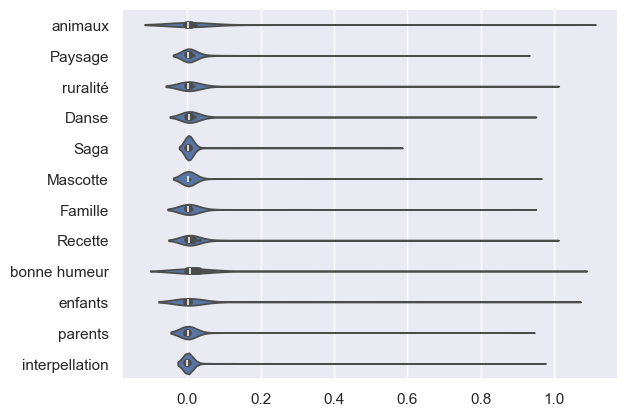

In [27]:
# Same but with violin plot

sns.violinplot(y=labels_bp_list, x=scores_bp_list)

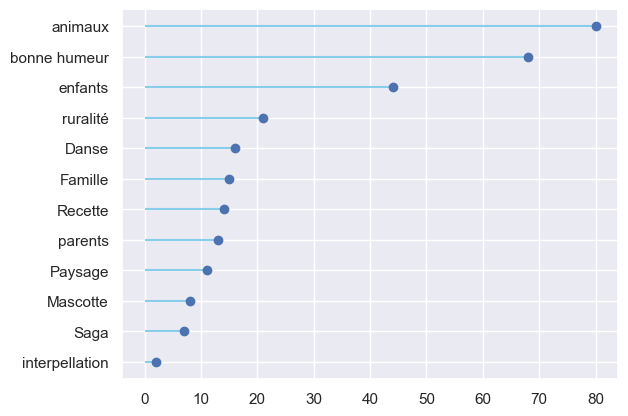

In [28]:
bool_scores_bp_list = [1 if x > .5 else 0 for x in scores_bp_list]
# labels_bp_list

# Dictionary to hold the sums
label_sums = {}

# Iterate through labels and values
for label, value in zip(labels_bp_list, bool_scores_bp_list):
    if label in label_sums:
        label_sums[label] += value
    else:
        label_sums[label] = value

label_sums = {k: v for k, v in sorted(label_sums.items(), key=lambda item: item[1])}

plt.hlines(y=range(1, len(label_sums.keys()) + 1), xmin=0,xmax=label_sums.values(), color='skyblue')
plt.plot(label_sums.values(), range(1, len(labels)+1), 'o')
plt.yticks(range(1, len(label_sums.keys())+1), label_sums.keys())
plt.show()

# Comparison before / after date

In [29]:
#Goal : get the proportion of ads with label before and after date

In [30]:
pivot_date = datetime.date(2017,1,1)

data_before_date = [x for x in data if arcom_df.loc[x['id'], 'clean_date'] < pivot_date]
data_after_date = [x for x in data if arcom_df.loc[x['id'], 'clean_date'] >= pivot_date]
ads_count_before_date = len(data_before_date)
ads_count_after_date = len(data_after_date)

labels_bp_list_before_date = list(itertools.chain(*[x['labels'] for x in data_before_date]))
scores_bp_list_before_date = list(itertools.chain(*[x['scores'] for x in data_before_date]))
labels_bp_list_after_date = list(itertools.chain(*[x['labels'] for x in data_after_date]))
scores_bp_list_after_date = list(itertools.chain(*[x['scores'] for x in data_after_date]))

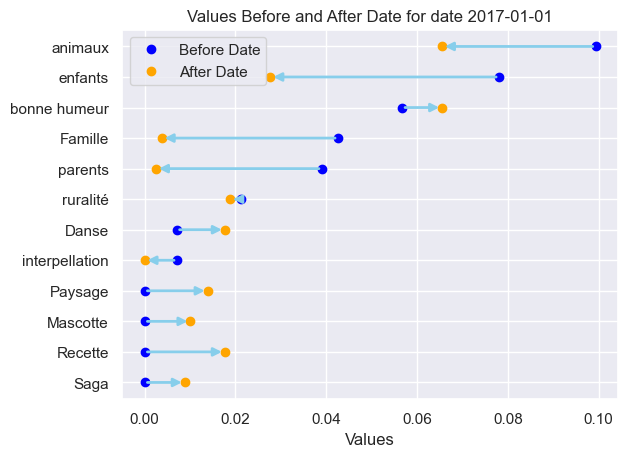

In [31]:
score_threshold = .5

bool_scores_bp_list_before_date = [1 if x > score_threshold else 0 for x in scores_bp_list_before_date]
bool_scores_bp_list_after_date = [1 if x > score_threshold else 0 for x in scores_bp_list_after_date]

# Dictionary to hold the sums
label_sums_before_date = {}

# Iterate through labels and values
for label, value in zip(labels_bp_list_before_date, bool_scores_bp_list_before_date):
    if label in label_sums_before_date:
        label_sums_before_date[label] += value
    else:
        label_sums_before_date[label] = value

label_sums_before_date = {k: v/ads_count_before_date for k, v in sorted(label_sums_before_date.items(), key=lambda item: item[1])}

# Same thing but with after date
label_sums_after_date = {}
for label, value in zip(labels_bp_list_after_date, bool_scores_bp_list_after_date):
    if label in label_sums_after_date:
        label_sums_after_date[label] += value
    else:
        label_sums_after_date[label] = value

# We want to have the same order as the dict of values before date
label_sums_after_date = {k: label_sums_after_date[k]/ads_count_after_date for k in label_sums_before_date.keys()}

# plot

fig, ax = plt.subplots()
for i in range(len(labels)):
    x_start = list(label_sums_before_date.values())[i]
    x_end = list(label_sums_after_date.values())[i]
    ax.annotate('', xy=(x_start, i+1), xytext=(x_end, i+1),
                arrowprops=dict(arrowstyle='<|-', color='skyblue', lw=2))

ax.plot(label_sums_before_date.values(), range(1, len(labels) + 1), 'o', color='blue', label='Before Date')
ax.plot(label_sums_after_date.values(), range(1, len(labels) + 1), 'o', color='orange', label='After Date')

ax.set_yticks(range(1, len(labels) + 1))
ax.set_yticklabels(label_sums_before_date.keys())

ax.set_xlabel('Values')
ax.set_title(f'Values Before and After Date for date {pivot_date}')
ax.legend()

# Show the plot
plt.show()

# Joyplots

In [15]:

start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

# Generate list of months
current_date = start_date
months = []

while current_date <= end_date:
    months.append(current_date.strftime("%Y-%m"))
    if current_date.month == 12:
        current_date = datetime.datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime.datetime(current_date.year, current_date.month + 1, 1)

In [16]:
threshold = .5

jp_viz_data = {month: {
        label: 0 for label in data[0]['labels']  
    } 
    for month in months}



for row in data:
    arcom_row = arcom_df.loc[row['id']]
    year_month = arcom_row['clean_date'].strftime("%Y-%m")
    labels_to_keep_count = len([x for x in row['scores'] if x > threshold])
    labels_to_keep = row['labels'][0:labels_to_keep_count]
    for label in labels_to_keep:
        jp_viz_data[year_month][label] += 1


In [17]:
jp_viz_df = pd.DataFrame.from_dict(jp_viz_data, orient='index').reset_index()
jp_viz_df['index'] = jp_viz_df['index'].map(lambda x: pd.to_datetime(x))
jp_viz_df.set_index('index', inplace=True)

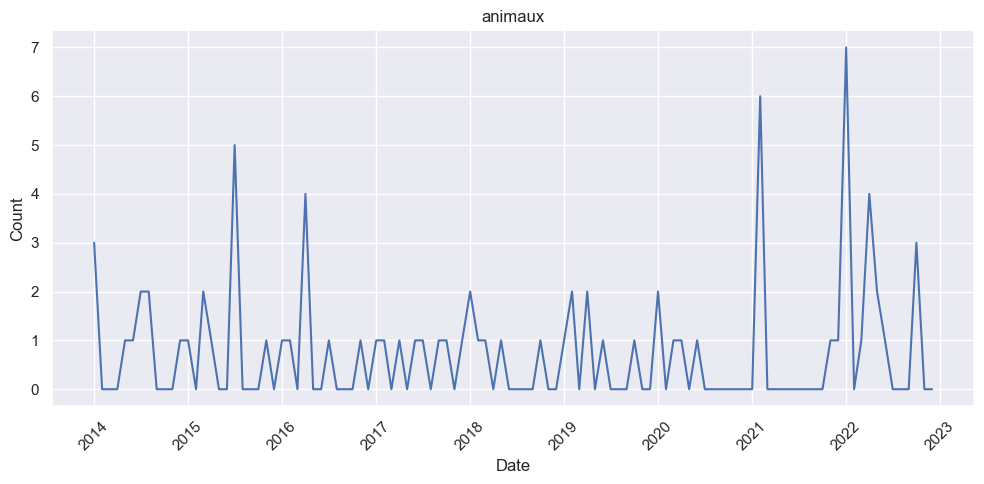

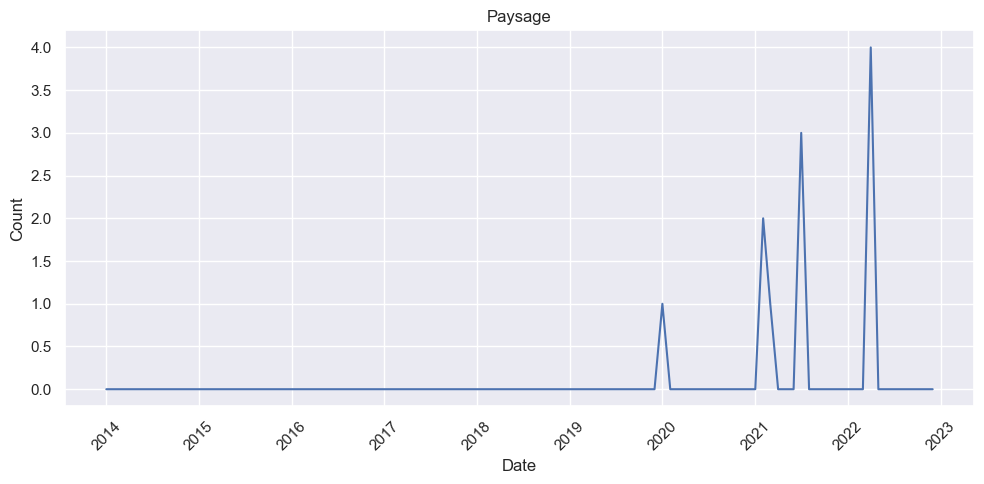

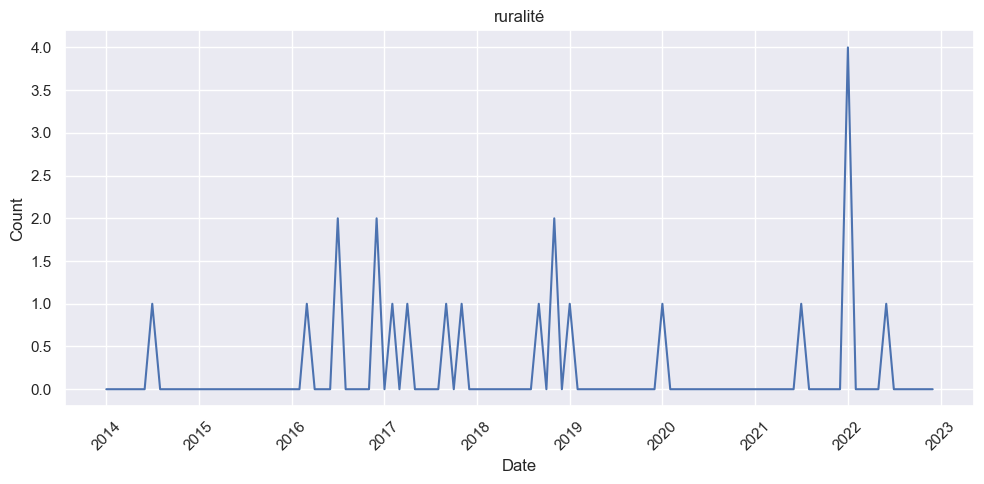

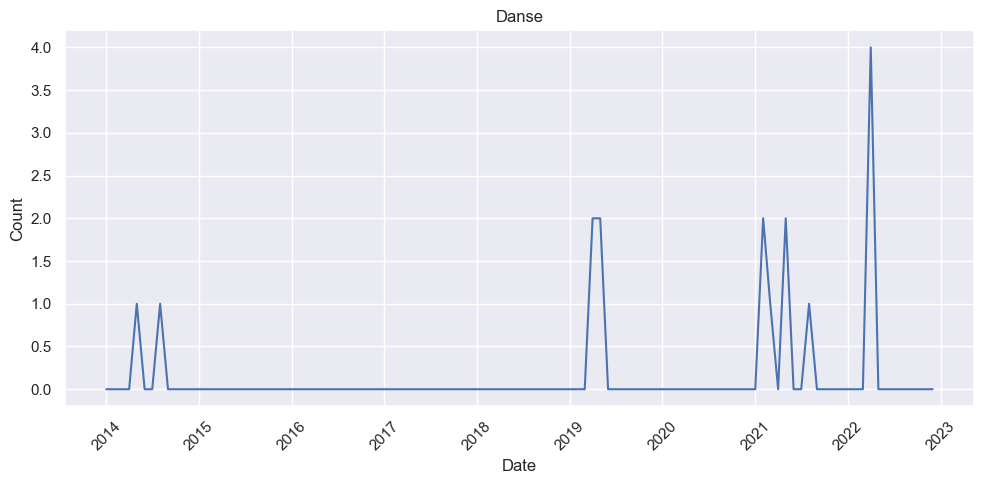

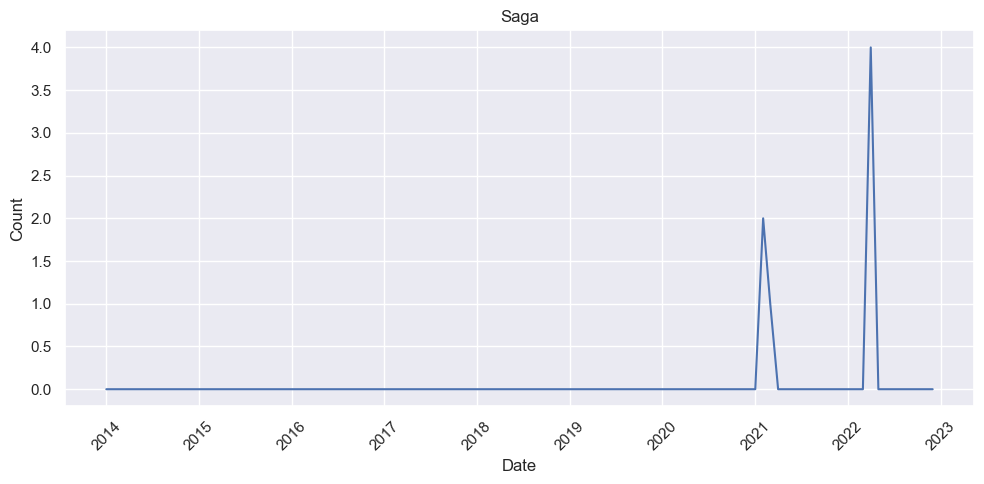

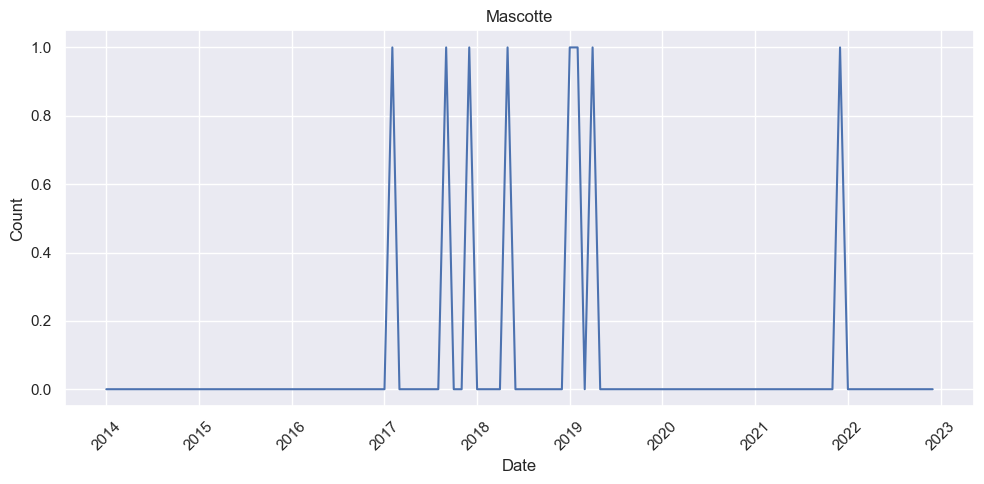

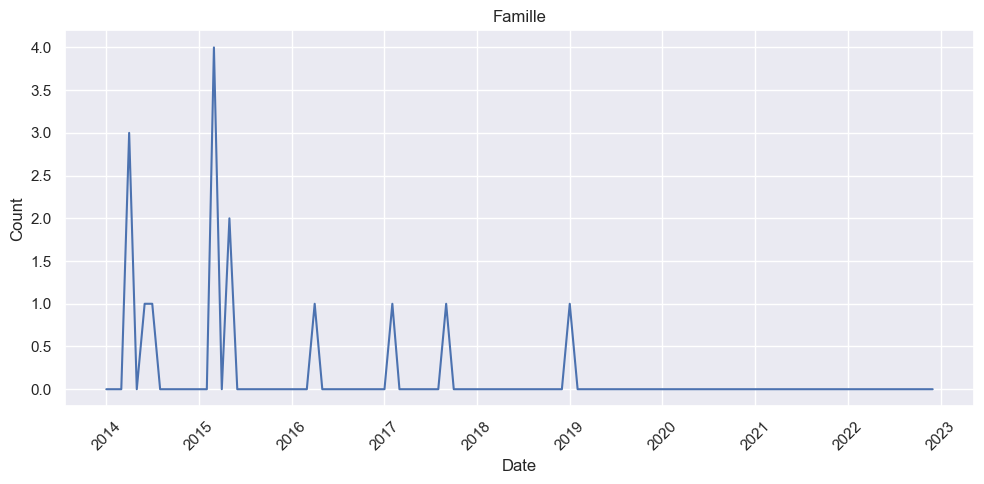

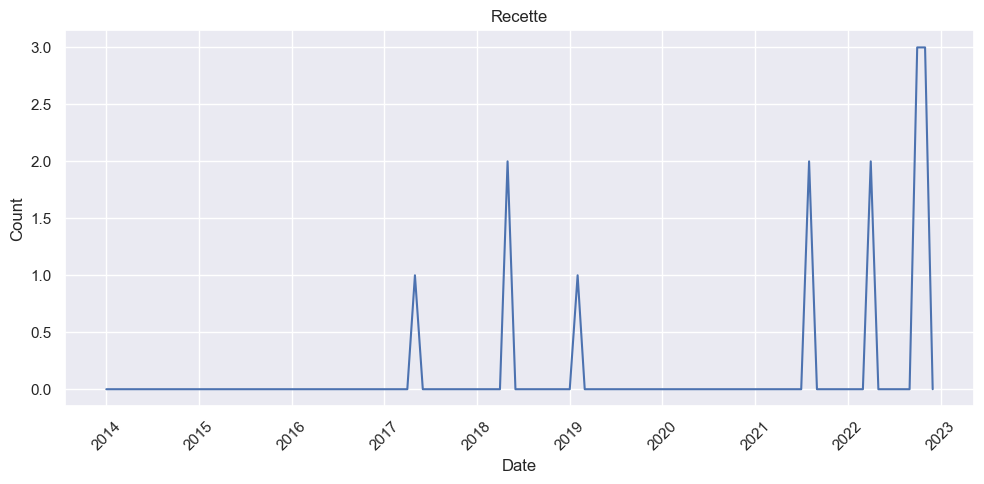

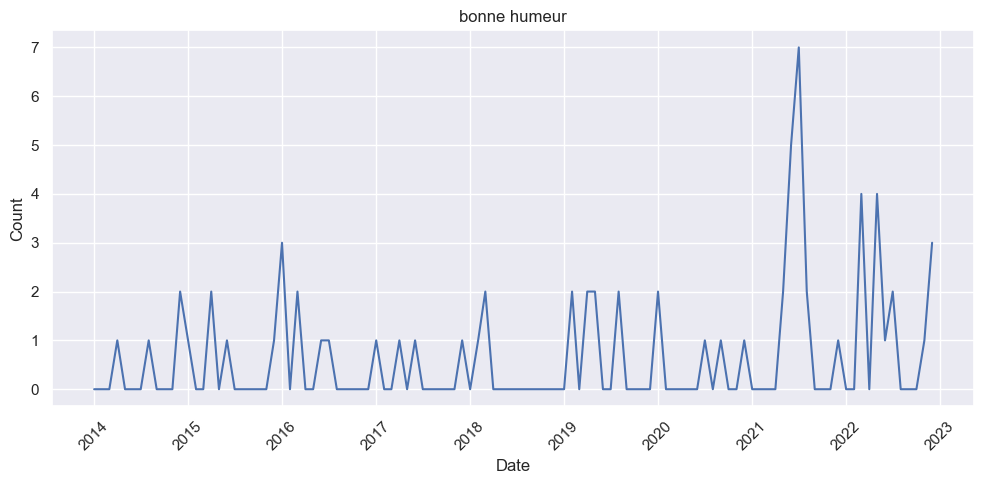

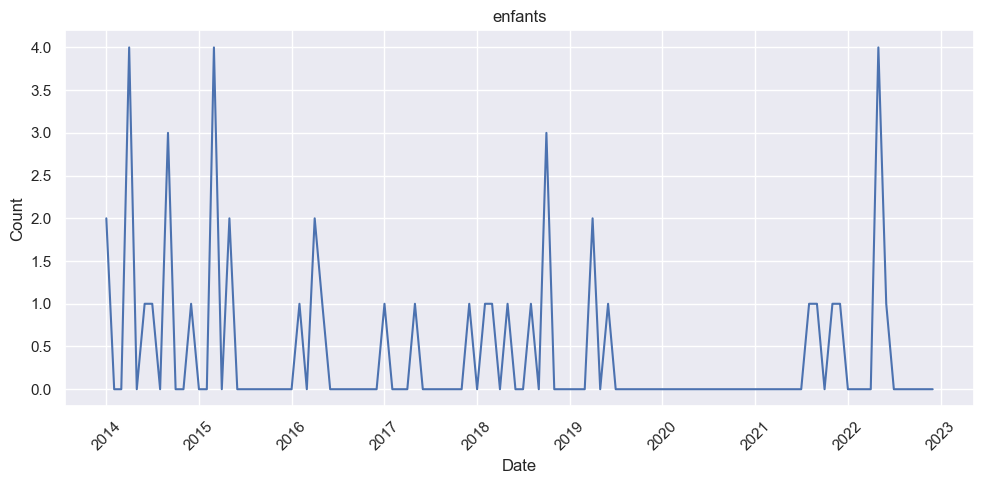

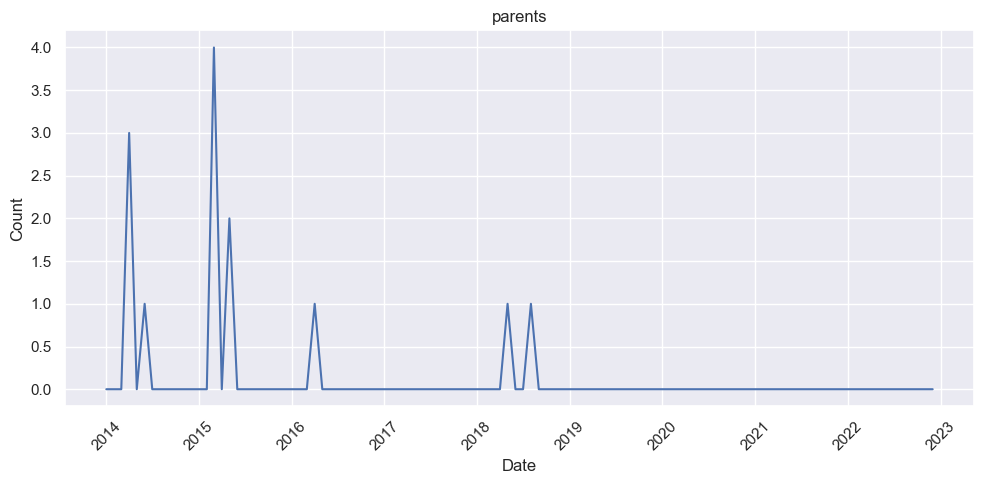

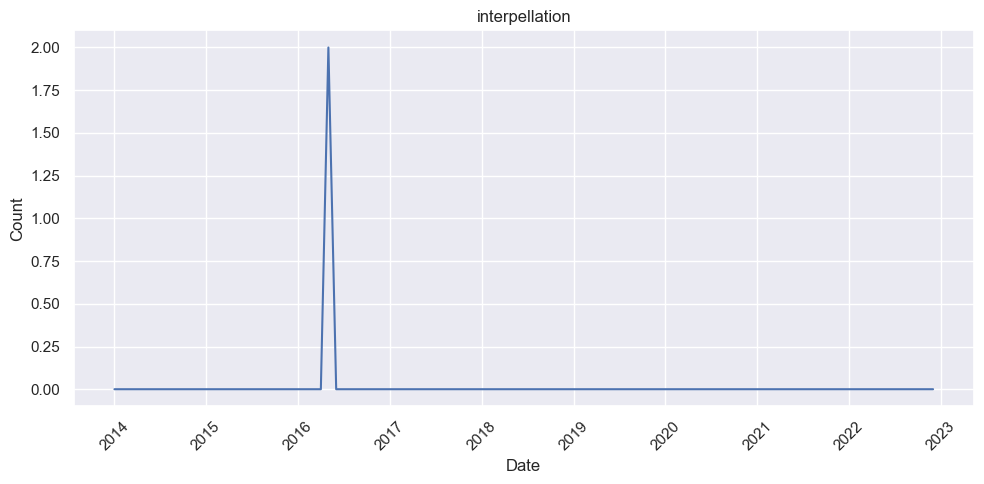

In [18]:
for label in labels:
    # Plot the time series data
    plt.figure(figsize=(10, 5))
    plt.plot(jp_viz_df.index, jp_viz_df[label], linestyle='-')
    plt.title(label)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()